# Tutorial1: data integration for Agg_PBMC data (scAI)

在聚合的PBMC数据（3197cells）上运行FGOT，其中cost的建立来自于多种sota的多组学整合方法。

## load package

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:

In [2]:
import importlib
import pkgutil

def reload_package(package):
    for _, module_name, _ in pkgutil.walk_packages(package.__path__, package.__name__ + '.'):
        try:
            module = importlib.import_module(module_name)
            importlib.reload(module)
            print(f"Reloaded: {module_name}")
        except Exception as e:
            print(f"Failed to reload: {module_name}, due to {e}")

In [3]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

In [4]:
reload_package(FGOT)

Reloaded: FGOT.fgot
Reloaded: FGOT.fgot_solver
Reloaded: FGOT.metrics
Reloaded: FGOT.preprocess
Reloaded: FGOT.utils


## load data

In [5]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)

RNA_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
ATAC_cluster = RNA_cluster.copy()

In [6]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (3197, 7835)  X2 =  (3197, 215)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## build a priori feature graph

In [7]:
promoters = pd.read_csv("/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/hg38.promoter.regions.txt", sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [8]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

72337it [00:01, 56626.09it/s] 
41399it [00:06, 6524.08it/s] 
100%|██████████| 215/215 [00:04<00:00, 49.00it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 215 7835 9115


100%|██████████| 9115/9115 [00:00<00:00, 260355.22it/s]


,NIPAL3,RCAN3AS,RCAN3,HYI,CD52,GAS5,LINC01135,COL24A1,RPL5,DIPK1A,...,PRKCH,PTGDR,GZMH,TNFAIP2,CEP128,TCF4,BCL2,LINC01478,SETBP1,TTC39C
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,1.0,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

In [1]:
import anndata
file_path = "/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/"

In [2]:
adata_tmp = anndata.read(file_path + "aggPBMC_scAI_adata.h5ad")
adata_tmp

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3197 × 30
    obs: 'label'
    var: 'mean', 'std'
    uns: 'label_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
smi = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(smi, 1)

In [6]:
import numpy as np

# 获取每一行中最大的 5 个值
max_5_values = np.sort(smi, axis=1)[:10, -5:]
print("每一行中最大的5个值：\n", max_5_values)

每一行中最大的5个值：
 [[0.5827168  0.59178615 0.9821374  1.         1.        ]
 [0.5174029  0.5342853  0.5612819  1.         1.        ]
 [0.7061027  1.         1.         1.         1.        ]
 [0.8345015  1.         1.         1.         1.        ]
 [0.7215054  0.72463065 0.7435038  1.         1.        ]
 [0.99999994 0.99999994 1.         1.         1.        ]
 [0.5342853  0.6248624  1.         1.         1.        ]
 [0.6188415  0.7685759  1.         1.         1.        ]
 [0.7789223  0.8340148  0.83584416 1.         1.        ]
 [0.9193228  1.         1.         1.         1.        ]]


In [12]:
cost = np.array(np.exp(1 - smi))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost')

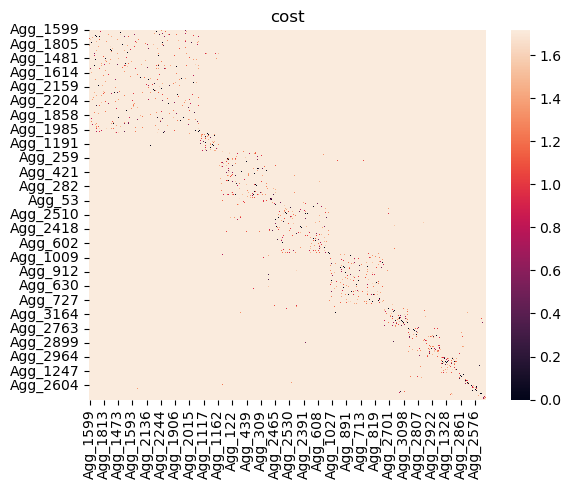

In [13]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
#sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_cols]
sns.heatmap(sorted_cost)
pl.title('cost')

## scale

In [14]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [15]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:6', eps_p = 1e-1)

import pickle
with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_scAI.pickle', 'wb') as file:
    pickle.dump(P_tensor, file)

minibatch = 1 and device =  cuda:6
the total number of computing batch is  6


100%|██████████| 6/6 [1:31:27<00:00, 914.58s/it]


In [16]:
import torch
torch.cuda.empty_cache()

In [ ]:
import pickle

# 从pickle文件读取数据
with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_scAI.pickle', 'rb') as file:
    P_tensor = pickle.load(file)

## make multi-omics alignment from the transport tensor

In [17]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 9115/9115 [20:14<00:00,  7.51it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

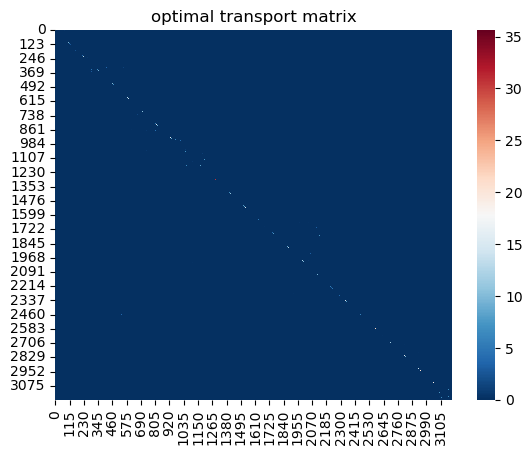

In [18]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [19]:
X1_aligned, X2_aligned = align(X1, X2, P)

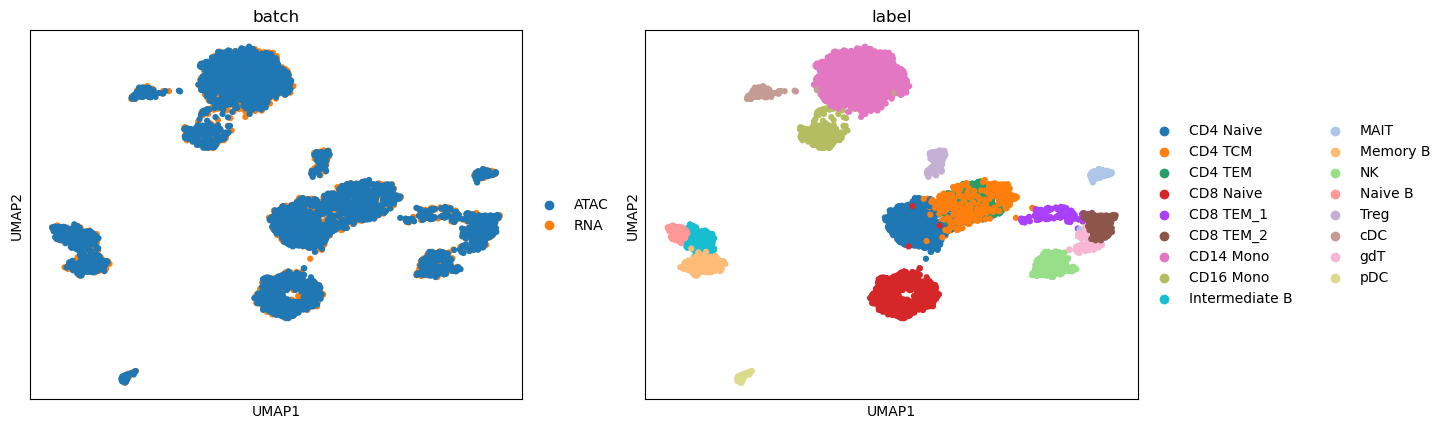

In [20]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_pdf/aggPBMC_FGOT_scAI_align.pdf")

In [21]:
adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_scAI_adata.h5ad")

## infer the cell type specific regulatory intensity from the transport tensor

In [22]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 215/215 [1:57:36<00:00, 32.82s/it]  


,NK,CD16 Mono,CD14 Mono,Intermediate B,MAIT,CD4 TCM,pDC,CD8 Naive,gdT,Treg,CD8 TEM_1,CD4 TEM,Memory B,CD4 Naive,cDC,Naive B,CD8 TEM_2
SKAP1-chr17-48456637-48457880,1.194692e-05,8.785899e-07,7.159568e-08,0.000005,0.000106,9.079114e-06,0.000023,5.343611e-06,0.000035,0.000155,0.000021,2.119993e-05,0.000015,5.038988e-06,3.865876e-07,0.000012,2.532390e-05
SKAP1-chr17-48546588-48549046,1.338021e-05,7.824882e-07,1.693320e-07,0.000001,0.000018,6.121236e-06,0.000022,6.243864e-06,0.000008,0.000088,0.000004,1.170850e-05,0.000006,7.077896e-06,1.974617e-06,0.000003,1.578204e-05
SKAP1-chr17-48294194-48295986,1.610448e-05,1.376399e-06,1.903740e-07,0.000004,0.000192,1.376423e-05,0.000017,2.064059e-06,0.000047,0.000016,0.000024,7.482296e-06,0.000013,2.498403e-06,2.888303e-07,0.000015,1.827775e-05
SKAP1-chr17-48444176-48445511,1.570728e-05,6.119596e-07,1.823877e-08,0.000006,0.000048,7.051793e-06,0.000002,1.013093e-05,0.000088,0.000005,0.000022,1.115232e-05,0.000013,5.698790e-06,4.997917e-09,0.000005,3.269970e-05
SKAP1-chr17-48526772-48527749,1.436174e-05,6.641814e-07,1.153946e-07,0.000004,0.000017,5.170051e-06,0.000007,5.750197e-06,0.000021,0.000085,0.000023,1.245457e-05,0.000010,5.440331e-06,4.060526e-09,0.000003,1.142276e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATJ-chr1-61641679-61642101,1.674878e-05,1.141026e-05,1.186194e-06,0.000014,0.000000,9.595114e-06,0.000164,1.167155e-05,0.000000,0.000000,0.000044,9.346769e-05,0.000109,7.468087e-06,3.688475e-05,0.000150,7.494155e-06
NEGR1-chr1-72366388-72366903,5.009297e-05,6.630639e-05,5.242721e-05,0.000032,0.000000,2.464526e-08,0.003003,2.401915e-08,0.000000,0.000000,0.000000,1.062389e-06,0.000000,1.211860e-08,3.563637e-03,0.000065,0.000000e+00
NEGR1-chr1-72281087-72285474,6.814620e-05,1.374283e-04,4.473430e-05,0.000015,0.000002,3.915923e-07,0.006249,7.991202e-06,0.000000,0.000000,0.000009,5.984446e-06,0.000055,2.202727e-06,3.073495e-03,0.000009,9.500375e-09
NEGR1-chr1-72288865-72289444,6.437202e-07,7.027242e-05,5.691998e-05,0.000000,0.000000,7.540446e-09,0.000894,3.603098e-08,0.000000,0.000000,0.000015,9.434677e-07,0.000110,0.000000e+00,1.457314e-03,0.000050,0.000000e+00


In [23]:
intensity_df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_scAI_regulation.txt') 

# Tutorial2: data integration for Agg_PBMC data (upon MOJITOO)

在聚合的PBMC数据（3197cells）上运行FGOT，其中cost的建立来自于多种sota的多组学整合方法。

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:

In [2]:
import importlib
import pkgutil

def reload_package(package):
    for _, module_name, _ in pkgutil.walk_packages(package.__path__, package.__name__ + '.'):
        try:
            module = importlib.import_module(module_name)
            importlib.reload(module)
            print(f"Reloaded: {module_name}")
        except Exception as e:
            print(f"Failed to reload: {module_name}, due to {e}")

In [3]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

In [4]:
reload_package(FGOT)

Reloaded: FGOT.fgot
Reloaded: FGOT.fgot_solver
Reloaded: FGOT.metrics
Reloaded: FGOT.preprocess
Reloaded: FGOT.utils


## load data

In [5]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)

RNA_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
ATAC_cluster = RNA_cluster.copy()

In [6]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (3197, 7835)  X2 =  (3197, 215)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## build a priori feature graph

In [7]:
promoters = pd.read_csv("/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/hg38.promoter.regions.txt", sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [8]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

72337it [00:02, 26367.91it/s] 
41399it [00:07, 5665.96it/s] 
100%|██████████| 215/215 [00:08<00:00, 23.90it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 215 7835 9115


100%|██████████| 9115/9115 [00:00<00:00, 329495.91it/s]


,NIPAL3,RCAN3AS,RCAN3,HYI,CD52,GAS5,LINC01135,COL24A1,RPL5,DIPK1A,...,PRKCH,PTGDR,GZMH,TNFAIP2,CEP128,TCF4,BCL2,LINC01478,SETBP1,TTC39C
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,1.0,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

In [16]:
import anndata
file_path = "/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/"

In [18]:
adata_tmp = anndata.read(file_path + "aggPBMC_MOJITOO_adata.h5ad")
adata_tmp

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3197 × 0
    obs: 'louvain', 'label'
    uns: 'label_colors', 'louvain', 'louvain_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'atac_lsi', 'mojitoo', 'rna_pca'
    obsp: 'connectivities', 'distances'

In [19]:
smi = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(smi, 1)

In [20]:
cost = np.array(np.exp(1 - smi))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost')

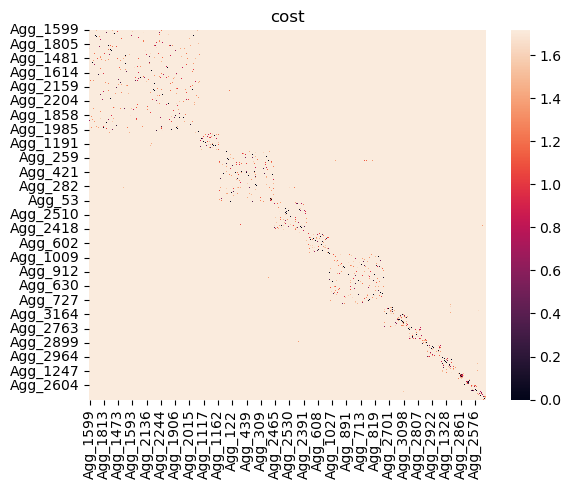

In [21]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
#sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_cols]
sns.heatmap(sorted_cost)
pl.title('cost')

## scale

In [22]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [26]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:6', eps_p = 1e-1)

import pickle
with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_MOJITOO.pickle', 'wb') as file:
    pickle.dump(P_tensor, file)

minibatch = 1 and device =  cuda:6
the total number of computing batch is  6


100%|██████████| 6/6 [1:45:10<00:00, 1051.80s/it]


In [27]:
import torch
torch.cuda.empty_cache()

In [ ]:
import pickle

# 从pickle文件读取数据
with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_MOJITOO.pickle', 'rb') as file:
    P_tensor = pickle.load(file)

## make multi-omics alignment from the transport tensor

In [28]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 9115/9115 [21:27<00:00,  7.08it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

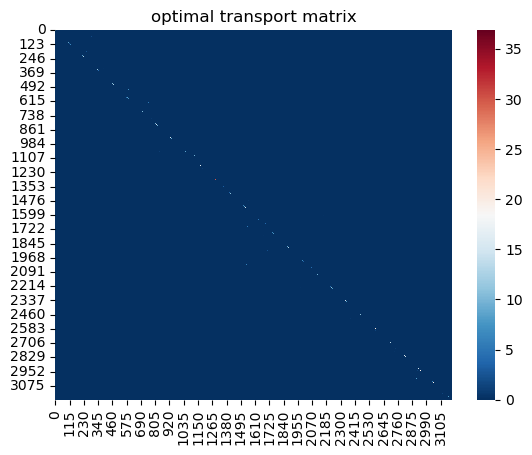

In [29]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [30]:
X1_aligned, X2_aligned = align(X1, X2, P)

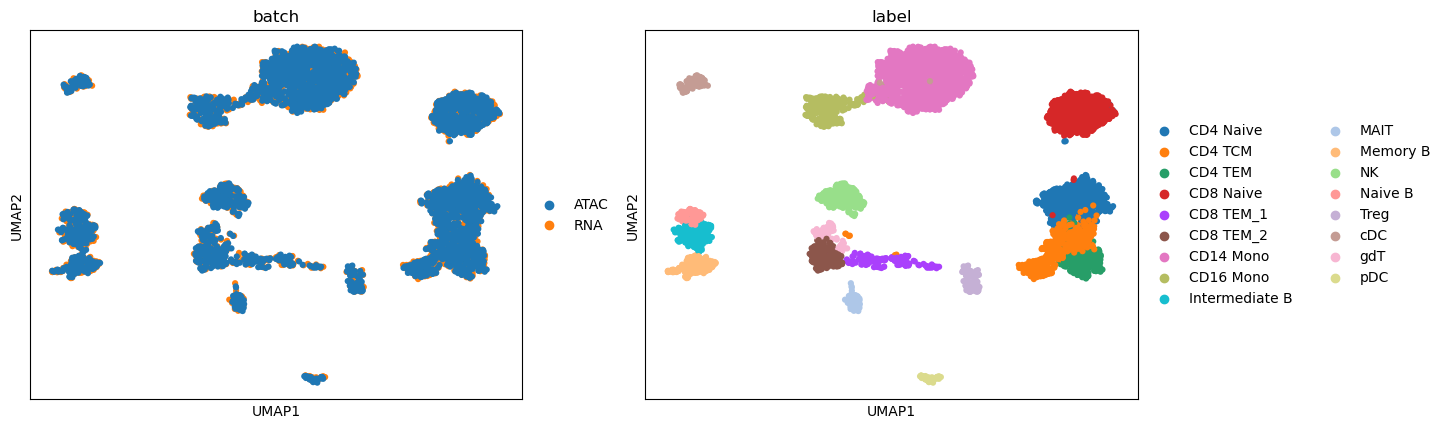

In [31]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_pdf/aggPBMC_FGOT_MOJITOO_align.pdf")

In [32]:
adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_MOJITOO_adata.h5ad")

## infer the cell type specific regulatory intensity from the transport tensor

In [33]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 215/215 [1:48:49<00:00, 30.37s/it]


,cDC,CD16 Mono,CD4 TCM,NK,pDC,CD4 TEM,CD4 Naive,CD14 Mono,Naive B,MAIT,CD8 Naive,Treg,Memory B,CD8 TEM_2,CD8 TEM_1,Intermediate B,gdT
SKAP1-chr17-48456637-48457880,3.791359e-07,8.229075e-07,9.614717e-06,1.216225e-05,2.321207e-05,2.393846e-05,5.030100e-06,5.997610e-08,1.301515e-05,0.000113,5.331722e-06,0.000152,0.000016,2.618752e-05,0.000025,5.745123e-06,0.000034
SKAP1-chr17-48546588-48549046,1.965940e-06,9.410930e-07,6.258521e-06,1.380648e-05,2.399352e-05,1.306193e-05,7.025635e-06,1.847943e-07,3.781367e-06,0.000020,6.118956e-06,0.000081,0.000006,1.575737e-05,0.000005,9.317046e-07,0.000008
SKAP1-chr17-48294194-48295986,2.866045e-07,1.375574e-06,1.480740e-05,1.648955e-05,2.146306e-05,8.722932e-06,2.568955e-06,2.182355e-07,1.352607e-05,0.000184,2.141049e-06,0.000018,0.000013,1.808169e-05,0.000024,4.134416e-06,0.000049
SKAP1-chr17-48444176-48445511,1.899784e-10,6.444335e-07,7.657929e-06,1.596600e-05,1.509072e-08,1.214792e-05,5.749659e-06,1.327994e-08,5.559883e-06,0.000048,1.046419e-05,0.000006,0.000014,3.448033e-05,0.000021,6.465102e-06,0.000090
SKAP1-chr17-48526772-48527749,8.218623e-10,1.034623e-06,5.088522e-06,1.405850e-05,9.192200e-06,1.392868e-05,5.227848e-06,1.262142e-07,3.572433e-06,0.000017,6.077024e-06,0.000079,0.000011,1.190062e-05,0.000025,4.263200e-06,0.000022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATJ-chr1-61641679-61642101,3.672709e-05,1.066874e-05,8.881460e-06,1.748819e-05,1.694869e-04,8.474595e-05,7.859563e-06,1.158622e-06,1.661399e-04,0.000000,1.143135e-05,0.000000,0.000076,1.124741e-05,0.000041,2.667327e-05,0.000000
NEGR1-chr1-72366388-72366903,3.412815e-03,5.942084e-05,1.742040e-08,5.564085e-05,3.159294e-03,1.040973e-06,1.600576e-07,5.358570e-05,1.097904e-04,0.000000,1.682545e-07,0.000000,0.000000,0.000000e+00,0.000000,2.429741e-05,0.000000
NEGR1-chr1-72281087-72285474,3.066256e-03,1.217506e-04,5.165859e-07,7.557337e-05,6.312213e-03,5.510823e-06,1.486268e-06,4.512776e-05,2.328123e-06,0.000005,7.049874e-06,0.000000,0.000057,3.788519e-07,0.000014,1.688162e-05,0.000000
NEGR1-chr1-72288865-72289444,1.431707e-03,5.938989e-05,0.000000e+00,1.866997e-07,8.922336e-04,1.411682e-07,0.000000e+00,5.470953e-05,5.222788e-07,0.000000,6.261442e-09,0.000000,0.000096,0.000000e+00,0.000015,0.000000e+00,0.000000


In [34]:
intensity_df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_MOJITOO_regulation.txt') 

# Tutorial3: data integration for Agg_PBMC data (MultiVI)

在聚合的PBMC数据（3197cells）上运行FGOT，其中cost的建立来自于多种sota的多组学整合方法。

## load package

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [25]:
import importlib
import pkgutil

def reload_package(package):
    for _, module_name, _ in pkgutil.walk_packages(package.__path__, package.__name__ + '.'):
        try:
            module = importlib.import_module(module_name)
            importlib.reload(module)
            print(f"Reloaded: {module_name}")
        except Exception as e:
            print(f"Failed to reload: {module_name}, due to {e}")

In [26]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

In [27]:
reload_package(FGOT)

Reloaded: FGOT.fgot
Reloaded: FGOT.fgot_solver
Reloaded: FGOT.metrics
Reloaded: FGOT.preprocess
Reloaded: FGOT.utils


## load data

In [28]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)

RNA_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
ATAC_cluster = RNA_cluster.copy()

In [29]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (3197, 7835)  X2 =  (3197, 215)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## build a priori feature graph

In [30]:
promoters = pd.read_csv("/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/hg38.promoter.regions.txt", sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [31]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

72337it [00:00, 76272.44it/s] 
41399it [00:04, 10320.05it/s]
100%|██████████| 215/215 [00:04<00:00, 49.97it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 215 7835 9115


100%|██████████| 9115/9115 [00:00<00:00, 1119176.84it/s]


,NIPAL3,RCAN3AS,RCAN3,HYI,CD52,GAS5,LINC01135,COL24A1,RPL5,DIPK1A,...,PRKCH,PTGDR,GZMH,TNFAIP2,CEP128,TCF4,BCL2,LINC01478,SETBP1,TTC39C
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,1.0,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

In [32]:
import anndata
file_path = "/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/"

In [33]:
adata_tmp = anndata.read(file_path + "aggPBMC_MultiVI_adata.h5ad")
adata_tmp

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3197 × 86320
    obs: '_indices', '_scvi_batch', '_scvi_labels', 'label'
    var: 'modality', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'label_colors', 'neighbors', 'umap'
    obsm: 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [34]:
smi = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(smi, 1)

In [35]:
cost = np.array(np.exp(1 - smi))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost')

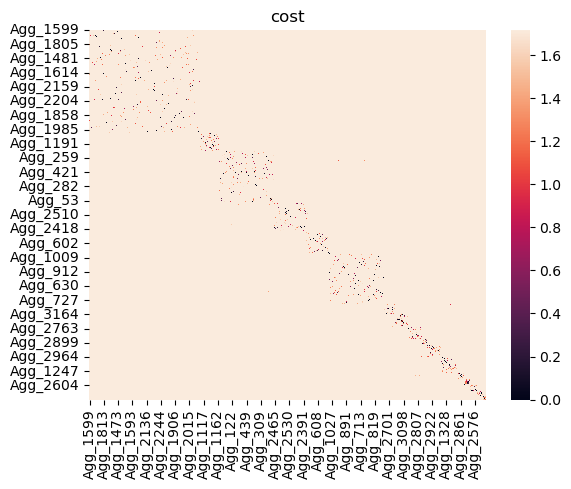

In [36]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
#sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_cols]
sns.heatmap(sorted_cost)
pl.title('cost')

## scale

In [37]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [38]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:6', eps_p = 1e-1)

import pickle
with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_MultiVI.pickle', 'wb') as file:
    pickle.dump(P_tensor, file)

minibatch = 1 and device =  cuda:6
the total number of computing batch is  6


100%|██████████| 6/6 [1:17:50<00:00, 778.36s/it]


In [39]:
import pickle

# 从pickle文件读取数据
with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_MultiVI.pickle', 'rb') as file:
    P_tensor = pickle.load(file)

## make multi-omics alignment from the transport tensor

In [40]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 9115/9115 [08:02<00:00, 18.91it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

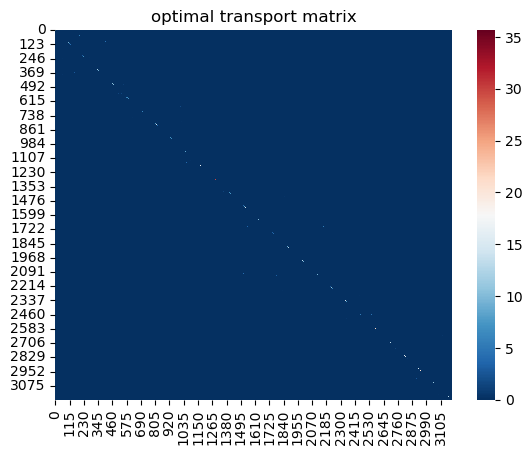

In [41]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [42]:
X1_aligned, X2_aligned = align(X1, X2, P)

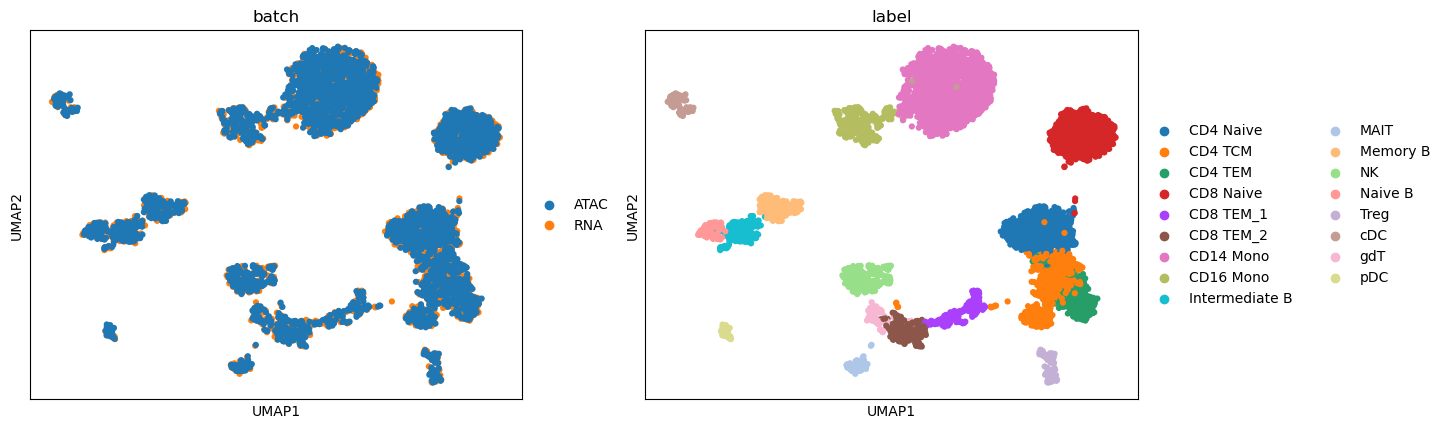

In [43]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_pdf/aggPBMC_FGOT_MultiVI_align.pdf")

In [44]:
adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_MultiVI_adata.h5ad")

## infer the cell type specific regulatory intensity from the transport tensor

In [45]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 215/215 [36:21<00:00, 10.15s/it] 


,NK,CD16 Mono,CD14 Mono,Intermediate B,MAIT,CD4 TCM,pDC,CD8 Naive,gdT,Treg,CD8 TEM_1,CD4 TEM,Memory B,CD4 Naive,cDC,Naive B,CD8 TEM_2
SKAP1-chr17-48456637-48457880,1.148697e-05,9.291015e-07,6.310863e-08,5.242416e-06,0.000108,9.340385e-06,2.357800e-05,5.358940e-06,0.000033,0.000154,0.000026,2.343698e-05,0.000016,5.075539e-06,5.130367e-07,1.125687e-05,2.630395e-05
SKAP1-chr17-48546588-48549046,1.316951e-05,7.712954e-07,2.135636e-07,8.630914e-07,0.000019,6.331727e-06,2.389930e-05,6.192084e-06,0.000008,0.000082,0.000005,1.274693e-05,0.000006,7.005309e-06,1.950271e-06,3.506296e-06,1.500005e-05
SKAP1-chr17-48294194-48295986,1.623158e-05,1.543472e-06,1.726119e-07,4.422454e-06,0.000190,1.465476e-05,2.070293e-05,2.193576e-06,0.000046,0.000016,0.000024,8.754053e-06,0.000013,2.562902e-06,3.531931e-07,1.261119e-05,1.899289e-05
SKAP1-chr17-48444176-48445511,1.566132e-05,6.240077e-07,1.429552e-08,6.290427e-06,0.000046,7.735418e-06,9.142520e-10,1.048415e-05,0.000092,0.000003,0.000022,1.260844e-05,0.000013,5.885882e-06,8.866685e-11,5.436236e-06,3.405965e-05
SKAP1-chr17-48526772-48527749,1.407606e-05,7.276972e-07,1.230481e-07,3.851074e-06,0.000020,5.562771e-06,7.358444e-06,5.866065e-06,0.000023,0.000081,0.000027,1.334631e-05,0.000011,5.400491e-06,1.940846e-10,2.948405e-06,1.219103e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATJ-chr1-61641679-61642101,1.852637e-05,1.189311e-05,1.228718e-06,1.868785e-05,0.000000,9.398987e-06,1.637871e-04,1.114736e-05,0.000000,0.000000,0.000038,8.817002e-05,0.000075,7.688402e-06,3.437299e-05,1.505210e-04,6.686801e-06
NEGR1-chr1-72366388-72366903,5.411245e-05,5.695092e-05,5.304767e-05,1.823998e-05,0.000000,2.850664e-08,2.965338e-03,1.875261e-08,0.000000,0.000000,0.000000,1.610209e-06,0.000000,2.425676e-07,3.350124e-03,6.484981e-05,0.000000e+00
NEGR1-chr1-72281087-72285474,6.959312e-05,1.288417e-04,4.496959e-05,1.747096e-05,0.000002,3.065957e-07,6.211467e-03,7.978501e-06,0.000000,0.000000,0.000009,6.625487e-06,0.000060,1.776406e-06,3.011456e-03,2.068921e-05,3.012997e-07
NEGR1-chr1-72288865-72289444,1.606389e-07,6.049500e-05,5.494179e-05,0.000000e+00,0.000000,6.100446e-07,7.401624e-04,1.438298e-08,0.000000,0.000000,0.000015,5.628126e-08,0.000092,0.000000e+00,1.454665e-03,3.448177e-07,0.000000e+00


In [46]:
intensity_df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_MultiVI_regulation.txt') 

# Tutorial4: data integration for Agg_PBMC data (GLUE)

在聚合的PBMC数据（3197cells）上运行FGOT，其中cost的建立来自于多种sota的多组学整合方法。

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/utils.py:

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [4]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)

RNA_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
ATAC_cluster = RNA_cluster.copy()

In [5]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (3197, 7835)  X2 =  (3197, 215)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## build a priori feature graph

In [6]:
promoters = pd.read_csv("/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/hg38.promoter.regions.txt", sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [7]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

72337it [00:00, 132160.38it/s]
41399it [00:01, 21428.97it/s]
100%|██████████| 215/215 [00:01<00:00, 117.74it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 215 7835 9115


100%|██████████| 9115/9115 [00:00<00:00, 824123.32it/s]


,NIPAL3,RCAN3AS,RCAN3,HYI,CD52,GAS5,LINC01135,COL24A1,RPL5,DIPK1A,...,PRKCH,PTGDR,GZMH,TNFAIP2,CEP128,TCF4,BCL2,LINC01478,SETBP1,TTC39C
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,1.0,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

In [8]:
import anndata
file_path = "/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/"

In [9]:
adata_tmp = anndata.read(file_path + "GLUE-combined.h5ad")
adata_tmp

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 6394 × 0
    obs: 'cell_type', 'domain', 'balancing_weight'
    uns: 'cell_type_colors', 'domain_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_umap'
    obsp: 'connectivities', 'distances'

In [10]:
atac_emd = adata_tmp[adata_tmp.obs["domain"] == "scATAC-seq"].obsm["X_glue"]
rna_emd = adata_tmp[adata_tmp.obs["domain"] == "scRNA-seq"].obsm["X_glue"]
atac_emd.shape, rna_emd.shape

((3197, 50), (3197, 50))

In [33]:
S_m = pre.calculate_cell_similarity_byMNN(atac_emd, rna_emd, cell_names1, cell_names2, scale=0, knn = 40)
r = pre.check_mnn_accuracy(S_m, basic_labels1, basic_labels2)
print("The accuracy of identifying MNN pairs is:", r)

the number of MNN pairs is  90380
The accuracy of identifying MNN pairs is: 0.9111211099548545


In [17]:
# import snn
s_tmp = adata_tmp.obsp['connectivities'].toarray()
np.fill_diagonal(s_tmp, 1)
snn1 = s_tmp[n2:,n2:] # ATAC
snn2 = s_tmp[:n2,:n2] # RNA

In [34]:
S_sm = pre.smooth_cell_similarity_byLaplacian2(S_m,snn1,snn2)
S = S_sm/np.max(S_sm) + S_m/np.max(S_m)

In [35]:
cost = np.array(np.exp(np.max(S) - S))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost')

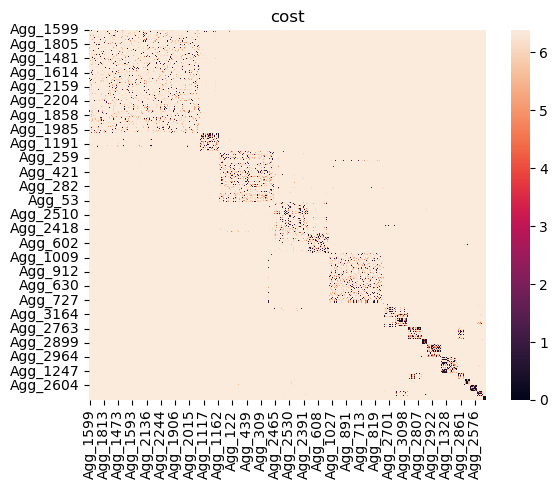

In [36]:
sorted_cols = np.argsort(basic_labels1)
sorted_cost = cost.iloc[sorted_cols,: ]
#sorted_rows = np.argsort(basic_labels2)
sorted_cost = sorted_cost.iloc[:, sorted_cols]
sns.heatmap(sorted_cost)
pl.title('cost')

## scale

In [21]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [37]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:6', eps_p = 1e-1)

import pickle
with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_GLUE.pickle', 'wb') as file:
    pickle.dump(P_tensor, file)

minibatch = 1 and device =  cuda:6
the total number of computing batch is  6


100%|██████████| 6/6 [1:03:00<00:00, 630.01s/it]


In [38]:
import torch
torch.cuda.empty_cache()

In [32]:
# import pickle

# # 从pickle文件读取数据
# with open('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_P_tensor/P_tensor_aggPBMC_GLUE.pickle', 'rb') as file:
#     P_tensor = pickle.load(file)

## make multi-omics alignment from the transport tensor

In [39]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 9115/9115 [05:18<00:00, 28.58it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

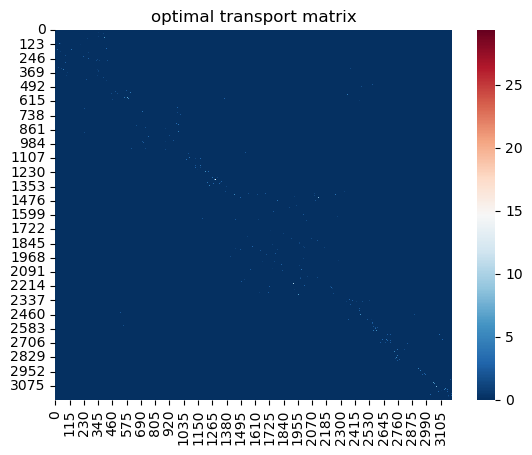

In [40]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [41]:
X1_aligned, X2_aligned = align(X1, X2, P)

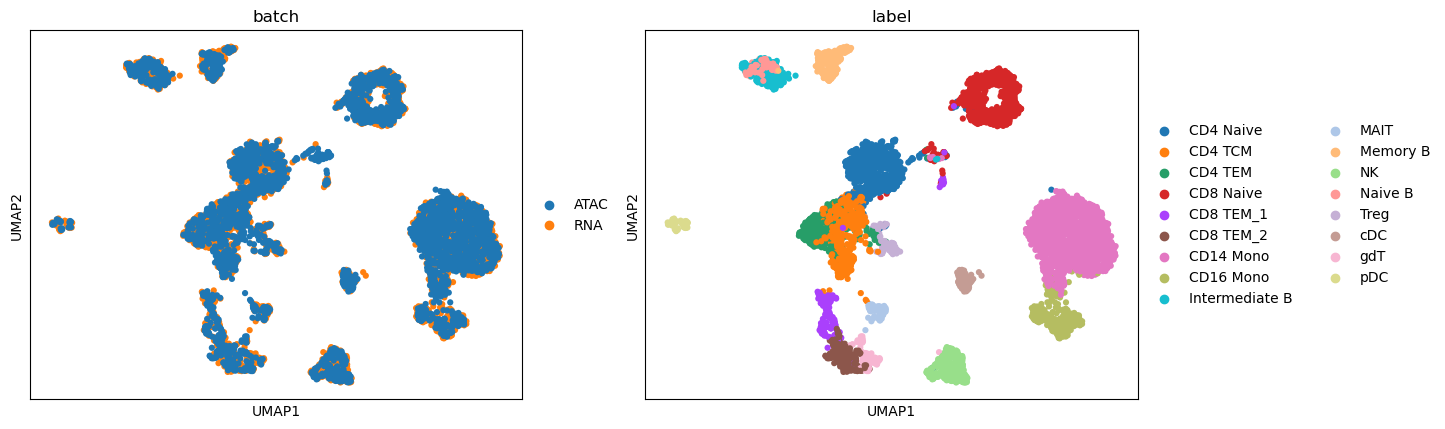

In [42]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)
pl.savefig("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/PBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE_pdf/aggPBMC_FGOT_GLUE_align.pdf")

In [43]:
adata_aligned.write_h5ad("/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_GLUE_adata.h5ad")

## infer the cell type specific regulatory intensity from the transport tensor

In [44]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 215/215 [30:27<00:00,  8.50s/it]


,cDC,CD16 Mono,Treg,CD4 TCM,NK,MAIT,CD14 Mono,CD4 Naive,Memory B,CD4 TEM,gdT,pDC,CD8 TEM_1,CD8 Naive,CD8 TEM_2,Intermediate B,Naive B
SKAP1-chr17-48456637-48457880,7.756043e-07,8.292437e-07,0.000109,6.890999e-06,0.000014,0.000106,9.378189e-08,5.252642e-06,0.000014,1.728029e-05,0.000031,0.000022,0.000020,4.789825e-06,0.000019,4.357832e-06,0.000004
SKAP1-chr17-48546588-48549046,9.139301e-07,8.680424e-07,0.000063,5.057048e-06,0.000012,0.000021,9.844016e-08,7.656649e-06,0.000008,1.094833e-05,0.000009,0.000016,0.000009,5.837668e-06,0.000011,3.480101e-07,0.000001
SKAP1-chr17-48294194-48295986,1.137970e-06,1.448047e-06,0.000007,1.171318e-05,0.000019,0.000175,2.504087e-07,2.127180e-06,0.000014,7.679060e-06,0.000037,0.000014,0.000019,1.659568e-06,0.000015,4.235310e-06,0.000005
SKAP1-chr17-48444176-48445511,3.166414e-07,3.428498e-07,0.000010,5.816515e-06,0.000014,0.000046,8.518865e-08,4.907336e-06,0.000012,1.107215e-05,0.000066,0.000003,0.000016,8.711526e-06,0.000025,3.693133e-06,0.000005
SKAP1-chr17-48526772-48527749,9.717811e-07,7.840155e-07,0.000070,4.277884e-06,0.000010,0.000018,8.409587e-08,4.847915e-06,0.000011,1.432342e-05,0.000024,0.000007,0.000025,7.378564e-06,0.000008,1.066700e-06,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATJ-chr1-61641679-61642101,2.681200e-05,1.260068e-05,0.000000,5.637695e-06,0.000018,0.000000,9.215606e-07,9.270026e-06,0.000086,9.115582e-05,0.000000,0.000153,0.000065,1.376234e-05,0.000007,2.311593e-05,0.000051
NEGR1-chr1-72366388-72366903,4.279641e-03,7.843273e-05,0.000000,4.911089e-09,0.000069,0.000000,5.535781e-05,7.543852e-07,0.000000,8.374777e-07,0.000000,0.003730,0.000000,6.524273e-08,0.000000,4.179808e-05,0.000066
NEGR1-chr1-72281087-72285474,3.501097e-03,1.407206e-04,0.000000,1.322683e-07,0.000088,0.000111,4.493503e-05,1.861263e-06,0.000088,1.138841e-05,0.000000,0.006790,0.000014,8.803458e-06,0.000007,1.731957e-05,0.000010
NEGR1-chr1-72288865-72289444,2.003588e-03,6.965442e-05,0.000000,1.041099e-06,0.000003,0.000000,5.741034e-05,0.000000e+00,0.000112,7.452130e-08,0.000000,0.000997,0.000014,5.227226e-09,0.000000,0.000000e+00,0.000036


In [ ]:
intensity_df.to_csv('/home/nas2/biod/yangchenghui/my_ych_project_PBMC/aggPBMC_in_scAI,scAI_MOJITOO_MultiVI_GLUE/aggPBMC_FGOT_GLUE_regulation.txt') 

: 